In [1]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

import pickle

import random
random.seed(123)

data_path = './data'

In [2]:
pct_anomalies = .01

In [3]:
!python prep_UNSW.py --pct_anomalies $pct_anomalies

c:\Users\arjun\Desktop\AnomalyDetection\prep_UNSW.py:25: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('./data/UNSW/UNSW-NB15_1.csv', header=None, names=col_names)
c:\Users\arjun\Desktop\AnomalyDetection\prep_UNSW.py:26: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('./data/UNSW/UNSW-NB15_2.csv', header=None, names=col_names)


In [4]:
filename = './preprocessed_unsw_data.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [5]:
for key in preprocessed_data:
    print(key)

x_train
y_train
x_test
y_test
le


In [6]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [7]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [8]:
input_dim = x_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 7

max_epochs = 10 

In [9]:
# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)

In [10]:
encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 94)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │         9,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,351 (75.59 KB)

 Trainable params: 19,351 (75.59 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# plot_model(
#     encoder_model, 
#     to_file='encoder_model.png', 
#     show_shapes=True, 
#     show_layer_names=True, 
#     rankdir='TB' # TB for top to bottom, LR for left to right
# )

# Image(filename='encoder_model.png')

In [12]:
# The decoder network is a mirror image of the encoder network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [13]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 94)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 96)             │         9,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_3 (Dense)               │ (None, 48)             │         3,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_4 (Dense)               │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_encoding (Dense)         │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 48)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Dense)               │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_4 (Dense)               │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reconstructed_data (Dense)      │ (None, 94)             │         9,118 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,789 (151.52 KB)

 Trainable params: 38,789 (151.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# plot_model(
#     autoencoder_model, 
#     to_file='autoencoder_model.png', 
#     show_shapes=True, 
#     show_layer_names=True, 
#     rankdir='TB' # TB for top to bottom, LR for left to right
# )

# Image(filename='autoencoder_model.png')

In [15]:
opt = optimizers.Adam(learning_rate=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [16]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

Epoch 1/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 1.0915e-05 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 1.9102e-06 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 4.2328e-06 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 1.8271e-06 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 6.7253e-07 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 7.3485e-07 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 1.2340e-06 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/10
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 1.

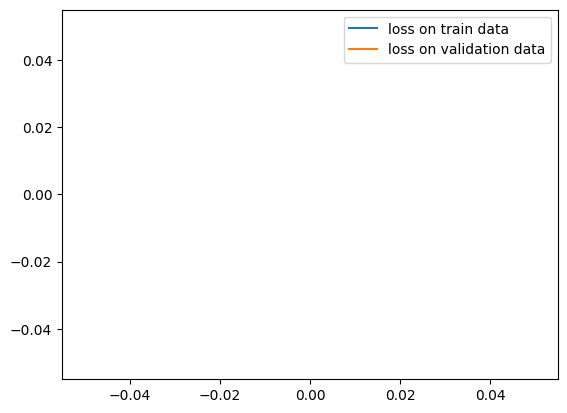

In [17]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5400), started 0:39:59 ago. (Use '!kill 5400' to kill it.)

In [19]:
# Reconstruct the data using our trainined autoencoder model.
x_test_recon = autoencoder_model.predict(x_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

27375/27375 ━━━━━━━━━━━━━━━━━━━━ 15s 537us/step


In [20]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()


,recon_score
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


<Axes: ylabel='Frequency'>

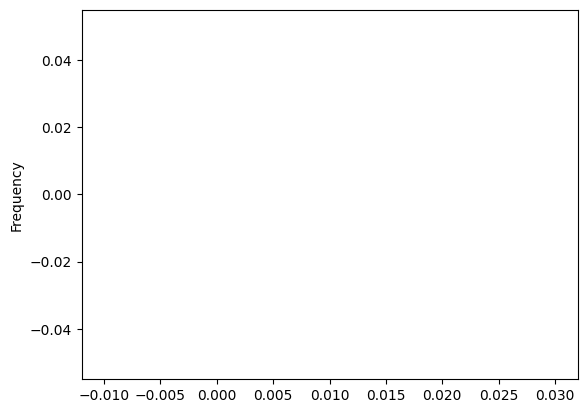

In [21]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])

In [22]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 0)[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

In [23]:
# convert our labels to binary
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                             
                    count mean std min 25% 50% 75% max
binary_labels                                         
0                     0.0  NaN NaN NaN NaN NaN NaN NaN
1                     0.0  NaN NaN NaN NaN NaN NaN NaN

In [24]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ValueError: Input contains NaN.

In [ ]:
# We can pick the threshold based on maximizing the true positive rate (tpr) 
# and minimizing the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.0129662175


In [ ]:
# Or we assume our reconstructions are normally distributed and label anomalies as those
# that are a number of standard deviations away from the mean
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)

stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

0.111230634


In [ ]:
# play around here and find the threshold that works for you

#thresh = optimal_threshold
thresh = stats_threshold



print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels) 

0.111230634


Confusion Matrix: 


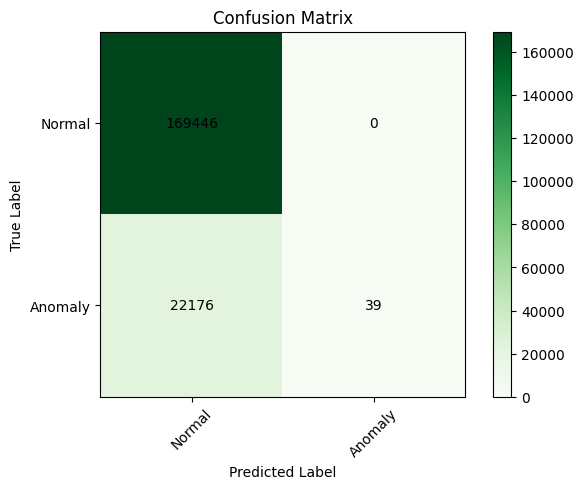

In [ ]:
print ('Confusion Matrix: ')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

In [ ]:
# subset the test data so that we are only looking at the predicted anomalies
x_test_df = pd.DataFrame(x_test)

test_anomalies = x_test_df[pred_labels.astype('bool')]

y_test_df = pd.DataFrame(y_test)
test_anomalies_labels = y_test_df[pred_labels.astype('bool')]

# encode the test anomalies into latent space
encoded_test_anomalies = encoder_model.predict(test_anomalies)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [ ]:
# apply KMeans to the data in order to create clusters of anomalies
kmeans = KMeans(n_clusters=10, random_state=123)
kmeans.fit(encoded_test_anomalies)

KMeans(n_clusters=10, random_state=123)

In [ ]:
clusters = pd.DataFrame({'cluster':kmeans.labels_, 'label':test_anomalies_labels[0]})

most_frequent_labels = clusters.groupby('cluster').label.value_counts()

print(most_frequent_labels)

cluster  label
0        1        5
1        1        5
2        1        4
3        1        2
4        1        2
5        1        1
6        1        2
7        1        5
8        1        5
9        1        8
Name: count, dtype: int64


In [ ]:
# this dictionary will map our cluster values to the labels that appear most frequently
cluster_to_label = {}
for cluster in range(0, 10):
    label = most_frequent_labels[cluster].index[0]
    cluster_to_label[cluster] = label

# we then replace the clusters inplace by their label values
clusters.cluster.replace(cluster_to_label, inplace=True)

C:\Users\arjun\AppData\Local\Temp\ipykernel_21204\3936171457.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clusters.cluster.replace(cluster_to_label, inplace=True)


Confusion Matrix :


C:\Users\arjun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


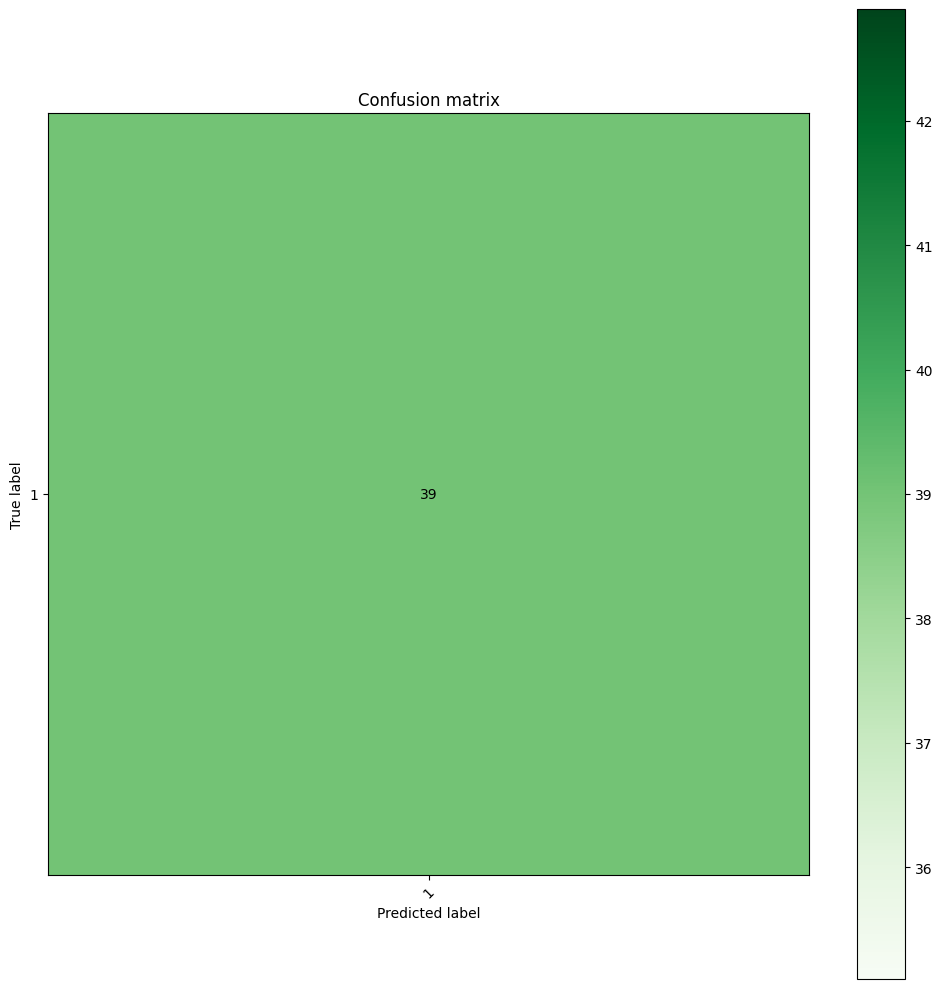

In [ ]:
target_names = np.unique(list(clusters.label))
cm = confusion_matrix(clusters.label, clusters.cluster)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm,target_names, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm,target_names)